C:\Users\migue\AppData\Local\Temp\ipykernel_41124\588035528.py:132: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ry_gate = RY(i, point[i])
C:\Users\migue\AppData\Local\Temp\ipykernel_41124\588035528.py:132: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ry_gate = RY(i, point[i])


The initial calssification is 32.432432432432435 % accurate


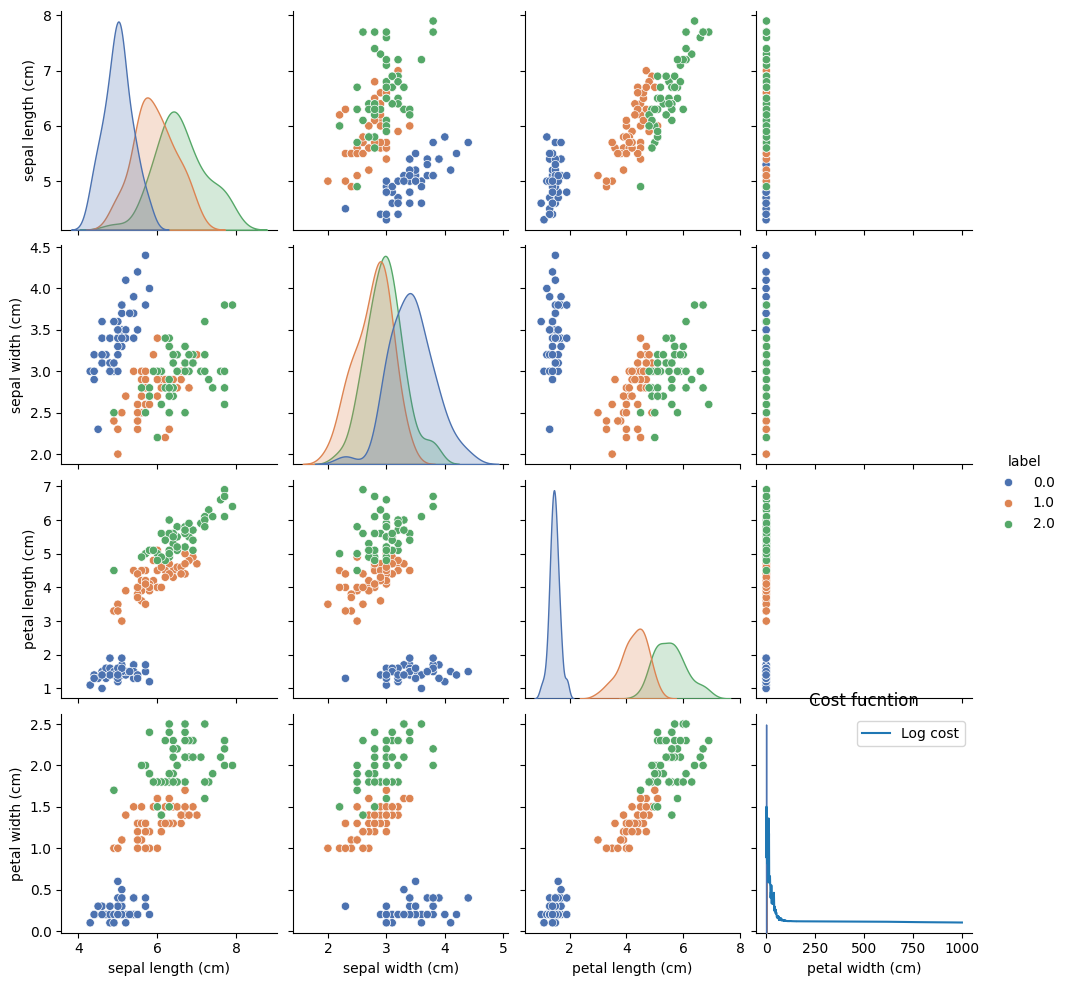

C:\Users\migue\AppData\Local\Temp\ipykernel_41124\588035528.py:398: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if test_df.iloc[i][5] == test_df.iloc[i][6]:


The final calssification is 92.03539823008849 % accurate.


C:\Users\migue\AppData\Local\Temp\ipykernel_41124\588035528.py:132: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ry_gate = RY(i, point[i])


KeyboardInterrupt: 

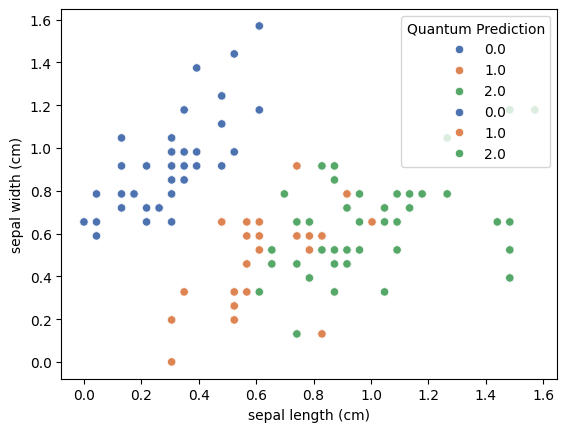

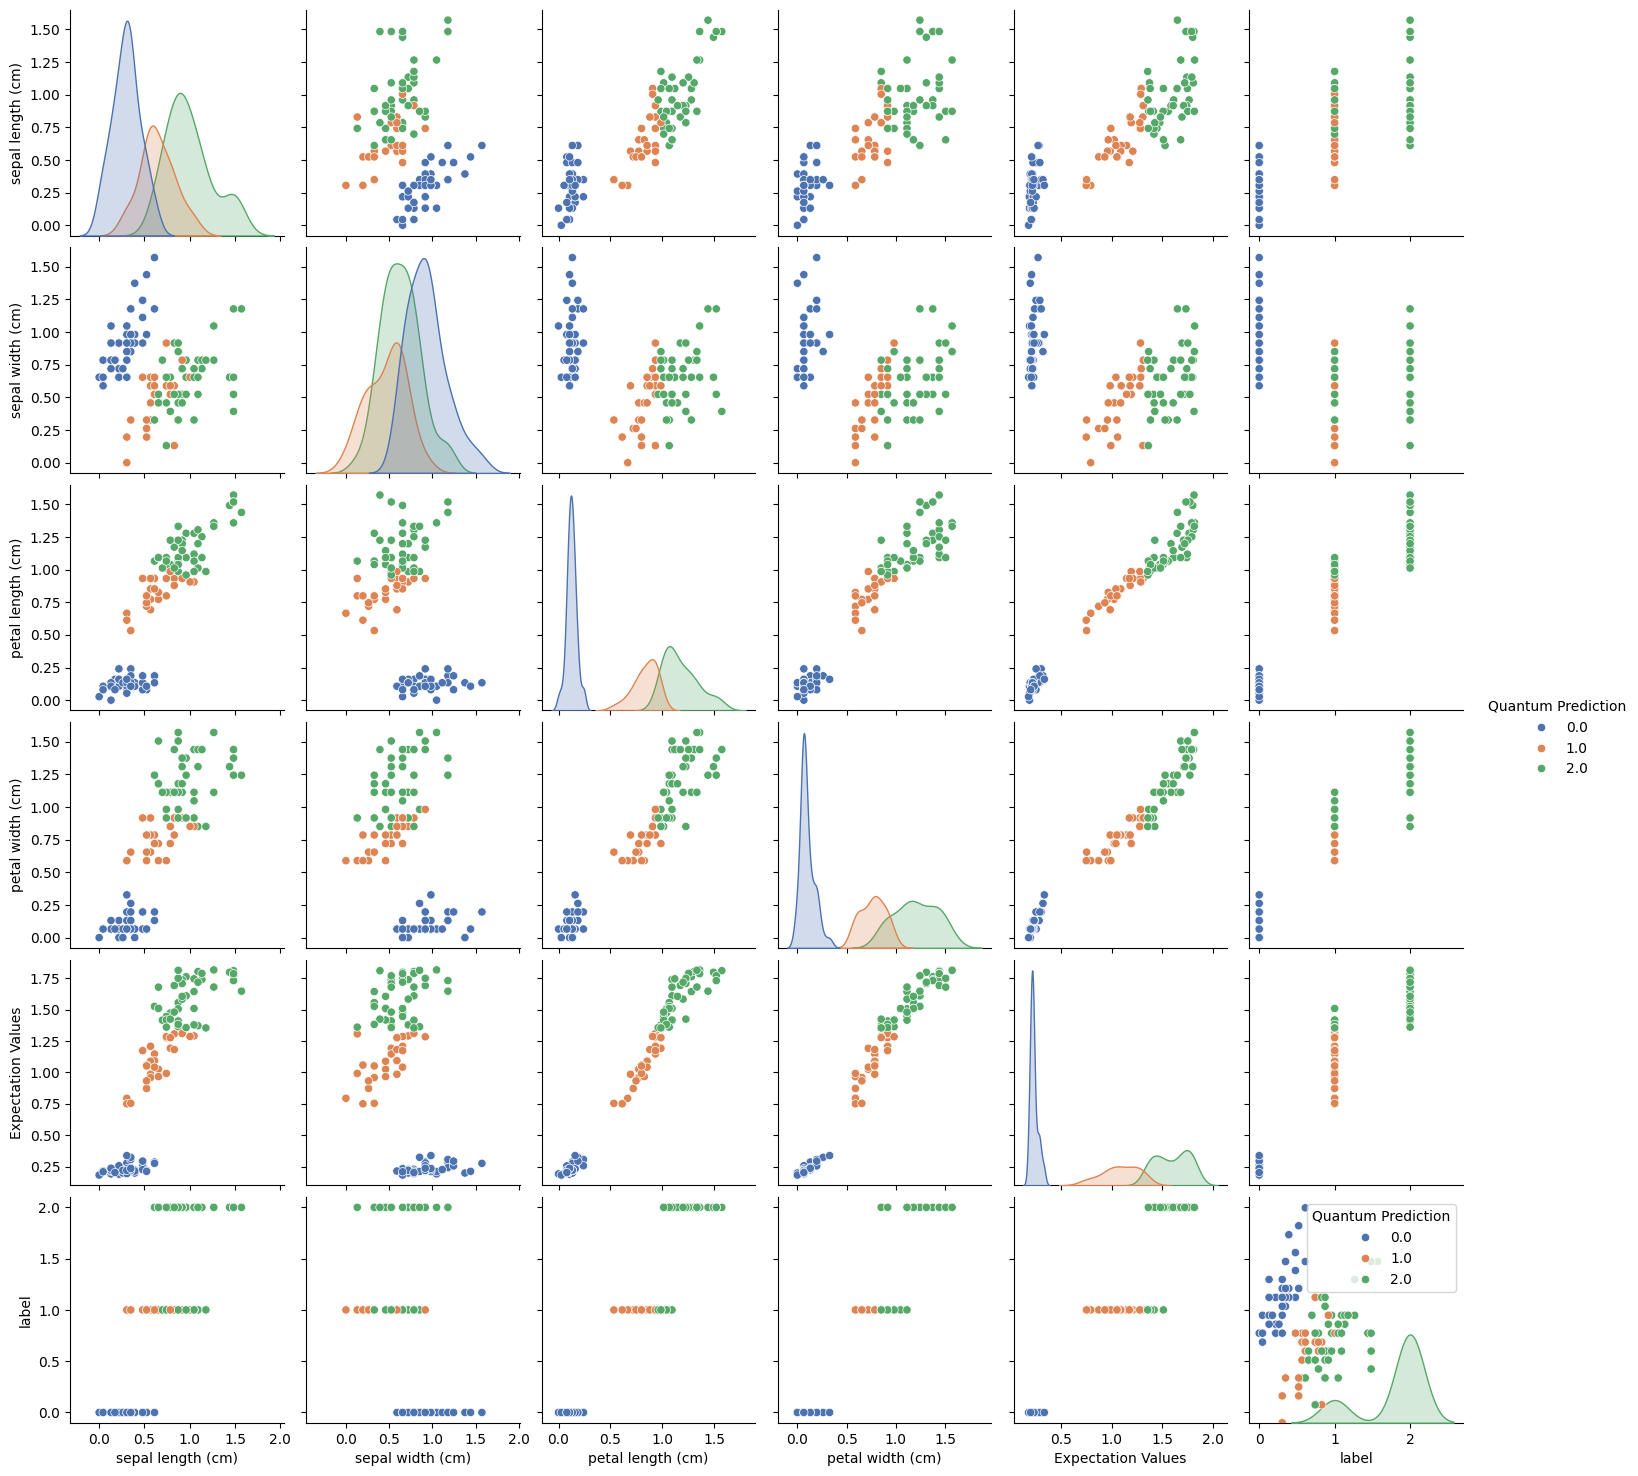

In [2]:

import qulacs
import numpy as np
from qulacs import QuantumState
from qulacs.gate import X, RY, RZ, DenseMatrix
from sklearn.datasets import load_iris
import seaborn as sns
import pandas as pd 
from matplotlib import pyplot as plt


iris = load_iris()
iris.DESCR

# %%
iris.data.shape,iris.target.shape

# %%
#Load iris data and classification to the same array.
features = iris.feature_names
features.append('label')
data = np.zeros((150,5))
data[:,0:4] = iris.data
data[:,4] = iris.target

# %%
iris_df = pd.DataFrame(data = data, columns = features)

# %%
iris_df.head(100)

# %%
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.75, random_state=42)

train_data = np.zeros((X_train.shape[0], X_train.shape[1] + 1))
train_data[:,0:4] = X_train
train_data[:,4] = y_train
train_df = pd.DataFrame(data = train_data, columns = features)

test_data = np.zeros((X_test.shape[0], X_test.shape[1] + 1))
test_data[:,0:4] = X_test
test_data[:,4] = y_test
test_df = pd.DataFrame(data = test_data, columns = features)

# %% [markdown]
# Featurewise pair plots:

# %%
sns.pairplot(iris_df, hue="label", palette = 'deep')

# %% [markdown]
# ## Data preprocessing, embedding and computational circuit

# %% [markdown]
# The data array has the form (x,y), where x is the feature vector and y is tge label. The feature vector has 4 element and the labels are 0,1,2 respectivly. To use a parameterised quantum circuit each data vector x must be transformed to a tensor product of qubits.
# 
# Encoding this data into qubits can be done in a number of ways. To begin with I will repeat the work done by Dominic, and use the qubit embedding $x_n^d \mapsto \bigotimes_{n=1}^4 cos(x_n^d) |0> + sin(x_n^d) |1>$ where $x_n^d$ is the nth feature of the dth sample. Note that this embedded state is the tensor product of 4 qubits, which gives a state vector of size $2^4 = 16$. Note also that for the qubit embedding we require all the x values be in the range $[0,\frac{\pi}{2})$.
# 
# To encode the data I will initialise 4 cubits in the $|0>$ computational basis state and operate on each them with the gate $U(X_n^d) := e^{-ix_n^d\sigma_y}$. This process will encode a single data points.
# 
# But first, the data will need normalising as described above.

# %% [markdown]
# ### Preprocessing

# %% [markdown]
# Test train split:

# %%
#This function takes a data set and returns a qubit embedding of the data.
#Normalise from the bottom
def half_pi_norm(data):
  #Normalise data
  dim = data.shape[1]
  min_values = np.zeros(dim)

  for i in range(dim):
    min_values[i] = np.amin(data[:,i])
    data[:,i] = data[:,i] - min_values[i]

  largest_values = np.zeros(dim)
  
  for i in range(dim):
    largest_values[i] = np.amax(data[:,i])


  #Normalise classical data
  normalised_data = np.zeros((data.shape[0],dim))

  for i in range(dim):

    normalised_data[:,i] = data[:,i]*(np.pi/(2*largest_values[i]))

  return normalised_data

# %% [markdown]
# Rescaled to be between 0 and pi/2 using pandas dataframe functions

# %%
train_df[train_df.columns[:4]] -= train_df[train_df.columns[:4]].min()
train_df[train_df.columns[:4]] /= train_df[train_df.columns[:4]].max()
train_df[train_df.columns[:4]] *= np.pi/2

# %%
train_df.head()

# %%
test_df[test_df.columns[:4]] -= test_df[test_df.columns[:4]].min()
test_df[test_df.columns[:4]] /= test_df[test_df.columns[:4]].max()
test_df[test_df.columns[:4]] *= np.pi/2

# %%
test_df.head()

# %%
#normed_train_data = half_pi_norm(X_train)
#normed_test_data = half_pi_norm(X_test)

# %% [markdown]
# ### Embedding circuit (Qubit Embedding)

# %% [markdown]
# Now I create the embedding circuit as a function that acts on a point and returns a quantum state.

# %%
#Function to perform pointwise qubit embedding.
def pointwise_qubit_embedding(point):
  n = len(point)
  state = QuantumState(n)
  state.set_zero_state()
  for i in range(n):
    ry_gate = RY(i, point[i])
    ry_gate.update_quantum_state(state)

  return state

# %% [markdown]
# ### Computational Circuit 

# %% [markdown]
# To build two qubit gates one needs to use combinations of single qubit gates and control operations.
# 
# I am copy the state after each operation for comparison.

# %% [markdown]
# Now its time for a parameterised quantum circuit.
# 
# Each two qubit unitary will be specified by two angles

# %%
from qulacs import ParametricQuantumCircuit
from qulacs import QuantumState
import numpy as np
#Circuit 6 Hur et al
def U_conv_6():
  #Metadata
  n = 4
  depth = 3
  angle = 0
  # construct parametric quantum circuit with random rotation
  circuit = ParametricQuantumCircuit(n)

  target_layer_1 = np.array([0,1,2,3], dtype = 'int')
  for i in target_layer_1:
    circuit.add_parametric_RY_gate(target_layer_1[i],angle)
  circuit.add_CNOT_gate(0,1)
  circuit.add_CNOT_gate(2,3)
  for i in target_layer_1:
    circuit.add_parametric_RY_gate(target_layer_1[i],angle)
  circuit.add_CNOT_gate(0,1)
  circuit.add_CNOT_gate(2,3)
  for i in target_layer_1:
    circuit.add_parametric_RY_gate(target_layer_1[i],angle)  
  circuit.add_CNOT_gate(1,2)

  target_layer_2 = [1,2]
  for i in range(len(target_layer_2)):
    circuit.add_parametric_RY_gate(target_layer_2[i],angle)
  circuit.add_CNOT_gate(1,2)
  for i in range(len(target_layer_2)):
    circuit.add_parametric_RY_gate(target_layer_2[i],angle)
  circuit.add_CNOT_gate(1,2)

  circuit.add_parametric_RY_gate(2,angle)

  return circuit

# %%
circuit = U_conv_6()
circuit.get_parameter_count

# %%
from qulacs import ParametricQuantumCircuit
from qulacs import QuantumState
import numpy as np
def U_dom():
  #Metadata
  n = 4
  depth = 3
  
  angle = 0
  # construct parametric quantum circuit with random rotation
  circuit = ParametricQuantumCircuit(n)

  target_layer_1 = np.array([0,1,2,3], dtype = 'int')
  for i in target_layer_1:
    circuit.add_parametric_RY_gate(target_layer_1[i],angle)
  circuit.add_CNOT_gate(0,1)
  circuit.add_CNOT_gate(3,2)

  target_layer_2 = [1,2]
  for i in range(len(target_layer_2)):
    circuit.add_parametric_RZ_gate(target_layer_2[i],angle)
  circuit.add_CNOT_gate(1,2)

  circuit.add_parametric_RY_gate(2,angle)

  return circuit

# %% [markdown]
# ## Get expectation
# 
# The below function will return the expectation scaled between 2 and 0.

# %%
def get_expectation(x, U, theta):
  #define PQC
  circuit =  U()
  for i in range(circuit.get_parameter_count()):
    circuit.set_parameter(i,theta[i])

  #Define and embed data point, x is an element of the normalised data set
  point = x
  state = pointwise_qubit_embedding(point)
  circuit.update_quantum_state(state)
  obs = Observable(4)
  obs.add_operator(1.,'Z 1')
  exp = obs.get_expectation_value(state)

  return exp + 1

# %% [markdown]
# 

# %% [markdown]
# # Trinary Clasification

# %%
from qulacs import Observable

# %% [markdown]
# ## prepare circuit data

# %%
circuit = U_conv_6()
theta_0 = np.random.rand(17)
for i in range(circuit.get_parameter_count()):
  circuit.set_parameter(i,theta_0[i])

# %%
circuit.get_parameter

# %%
parameter_count = circuit.get_parameter_count()
param = [circuit.get_parameter(ind) for ind in range(parameter_count)]

# %%
param

# %% [markdown]
# NOTE TO SELF
# 
# use pca on the components to see what the most important eigen vlaues/vectors are doing.

# %%
train_df.head()

# %% [markdown]
# ## Define operators and make initial predictions
# Initatial expectation and classification is prior to training.
# 
# I will use the Pauli Z operator to take the expectation of the unitary evolution of embedded data points.

# %%
from qulacs import PauliOperator
p_s = 'Z 1'
z = PauliOperator(p_s,1)

# %%
#Classify and expectation value that is reshaped to be between 0 and 2.
def classify_tri(exp):
  if exp >= 1.33:
    pred = 2
  elif exp < 1.33 and exp > 0.66:
    pred = 1
  else:
    pred = 0
  return pred

# %% [markdown]
# Below I visualise the naive predictions on the training data. Clearly the predictions are sub optimal.

# %%
expectation = []
for i in range(len(train_df)):
  expectation.append(get_expectation(train_df.iloc[i][0:4],U_conv_6,np.random.rand(17)))
train_df.insert(4,'Expectation', expectation)


# %% [markdown]
# Naive expectation values with random angle, very poor but thats expected.

# %%
def cost_train(theta):
  #get predictions
  expect = np.zeros(len(train_df))
  for i in range(len(train_df)):
    expect[i] = get_expectation(train_df.iloc[i][0:4],U_conv_6, theta)
  #Simple MSE example
  
  #Sxpectation values
  L = ((expect - y_train)**2).mean()
  cost_values.append(L)
  return L

# %%
theta = np.random.rand(17)

# %%
train_df.head()

# %%
#find number of correct predictions
correct = 0
for i in range(len(y_train)):
  if y_train[i] == classify_tri(train_df['Expectation'][i]):
    correct += 1

print('The initial calssification is',(correct/len(y_train)) * 100, '% accurate')


# %% [markdown]
# ## Optimise
# The updated parameters are generated and tested below:

# %%
from scipy.optimize import minimize #BFGS works well/cobyla

# %%
#%%time
#Use scipy minimised to find the vector theta that minimised the cost function.
cost_values = []
theta_0 = np.random.rand(17)
result = minimize(cost_train, theta_0, method='cobyla')

theta = result.x


# %%
plt.plot(np.linspace(0,len(cost_values)-1,len(cost_values)-1).round(),(cost_values[:-1]),label = 'Log cost')
#Plot the difference between the exact and trial function
plt.ylabel('L')
plt.xlabel('Iteration')
plt.title('Cost fucntion')
plt.legend(loc="best")
plt.show()

# %% [markdown]
# ## Reclasify

# %%
def cost_test(theta):
  #get predictions
  expect = np.zeros(len(test_df))
  for i in range(len(test_df)):
    expect[i] = get_expectation(test_df.iloc[i][0:4],U_conv_6,theta)
  #Simple MSE example
  L = ((expect - y_test)**2).mean()

  return L

# %%
cost_test(theta),cost_test(theta_0)

# %%
better_predictions = np.zeros(len(test_df))
expectations = np.zeros(len(test_df))
for i in range(len(test_df)):
  better_predictions[i] = classify_tri(get_expectation(test_df.iloc[i][0:4],U_conv_6, theta))
  expectations[i] = get_expectation(test_df.iloc[i][0:4],U_conv_6, theta)

test_df.insert(4,'Expectation Values', expectations)
test_df.insert(5,'Quantum Prediction', better_predictions)

# %%
correct = 0
for i in range(len(test_df)):
  if test_df.iloc[i][5] == test_df.iloc[i][6]:
    correct += 1 

print('The final calssification is',(correct/len(test_df)) * 100, '% accurate.')

# %% [markdown]
# ## Prediction graphs

# %%
sns.scatterplot(data=test_df, x=test_df.iloc[:,0], y=test_df.iloc[:,1], hue='label', palette="deep")

# %%
sns.scatterplot(data=test_df, x=test_df.iloc[:,0], y=test_df.iloc[:,1], hue='Quantum Prediction', palette="deep")

# %%
sns.pairplot(test_df, hue="Quantum Prediction", palette = 'deep')

# %%
sns.scatterplot(data=test_df, x=test_df.iloc[:,0], y=test_df.iloc[:,1], hue='Quantum Prediction', palette="deep")

# %% [markdown]
# Generate shadded boundary values by generating and fitting a model

# %% [markdown]
# ## Feature space landscape and local Interpretability of solution
# 
# Stop using pandas, its shit.
# 
# CPU/GPU kernel for classification

# %%
import numba
from numba import jit, njit

# %%
N = 30
w = np.linspace(0,np.pi/2,N, endpoint = True)
x = np.linspace(0,np.pi/2,N, endpoint = True)
y = np.linspace(0,np.pi/2,N, endpoint = True)
z = np.linspace(0,np.pi/2,N, endpoint = True)

ww, xx, yy, zz = np.meshgrid(w,x,y,z)

w_flat = ww.reshape(N**4)
x_flat = xx.reshape(N**4)
y_flat = yy.reshape(N**4)
z_flat = zz.reshape(N**4)
fs = np.array([w_flat,x_flat, y_flat, z_flat]).reshape(N**4,4)

feature_space = pd.DataFrame([w_flat,x_flat, y_flat, z_flat]).T
feature_space.columns = features[0:4]

# %%
feature_space

# %% [markdown]
# Make predictions on the feature space mesh grid

# %%
"""fs_pred = np.zeros(len(feature_space))

"""
def get_fs_pred():
  fs_exp = np.zeros(len(feature_space))
  fs_pred = np.zeros(len(feature_space))

  for i in range(N**4):
    fs_exp[i] = get_expectation(feature_space.iloc[i][0:4],U_conv_6, theta)
    fs_pred[i] = classify_tri(fs_exp[i])

  return fs_pred, fs_exp

  
pred, exp = get_fs_pred()
feature_space.insert(4,'Expectation Values', exp)
feature_space.insert(5,'Quantum Prediction', pred)

# %%
feature_space.reindex(np.random.permutation(feature_space.index)).head(40300)

# %%
feature_space['Expectation Values']

# %%
#feature_space = feature_space[feature_space['Quantum Prediction'] != 2]

# %%
#Plotting erros against dimension
plt.scatter(np.array(feature_space.iloc[:,0]),np.array(feature_space.iloc[:,1]),label = 'Error against dimension')

plt.xlabel(features[0])
plt.ylabel(features[1])
plt.title('Error compared to sample functions')
plt.legend(loc="best")
plt.show()

# %%
sns.pairplot(feature_space.sample(500), hue = 'Quantum Prediction', palette = 'deep')

# %% [markdown]
# # Binary Classification 

# %%
sns.scatterplot(data=data, x=data[:,0], y=data[:,1], hue=data[:,4], palette="deep")

# %% [markdown]
# 

# %%
sns.scatterplot(data=data, x=data[:,2], y=data[:,3], hue=data[:,4], palette="deep")

# %% [markdown]
# ## Convert and visualise data
# 
# The embedding and computational circuits will be unchanged.

# %%
#Copy data and alter labels for binar classification.
y_test_bi = y_test
y_train_bi = y_train

X_test_bi = X_test
X_train_bi = X_train

for i in range(len(X_test_bi)):
  if y_test_bi[i] == 2:
    y_test_bi[i] = 1

for i in range(len(y_train)):
  if y_train_bi[i] == 2:
    y_train_bi[i] = 1


# %%
X_test_bi[1]

# %%
normed_train_data_bi = half_pi_norm(X_train_bi)
normed_test_data_bi = half_pi_norm(X_test_bi)

# %%
X_train_bi, X_test_bi, y_train_bi, y_test_bi = train_test_split(iris.data, iris.target, test_size=0.33, random_state=42)

for i in range(len(y_test_bi)):
  if y_test_bi[i] == 2:
    y_test_bi[i] = 1

for i in range(len(y_train_bi)):
  if y_train_bi[i] == 2:
    y_train_bi[i] = 1

train_data_bi = np.zeros((X_train_bi.shape[0], X_train_bi.shape[1] + 1))
train_data_bi[:,0:4] = X_train_bi
train_data_bi[:,4] = y_train_bi
train_df_bi = pd.DataFrame(data = train_data_bi, columns = features)

test_data_bi = np.zeros((X_test_bi.shape[0], X_test_bi.shape[1] + 1))
test_data_bi[:,0:4] = X_test_bi
test_data_bi[:,4] = y_test_bi
test_df_bi = pd.DataFrame(data = test_data_bi, columns = features)

# %%
train_df_bi[train_df_bi.columns[:4]] -= train_df_bi[train_df_bi.columns[:4]].min()
train_df_bi[train_df_bi.columns[:4]] /= train_df_bi[train_df_bi.columns[:4]].max()
train_df_bi[train_df_bi.columns[:4]] *= np.pi/2

# %%
test_df_bi[test_df_bi.columns[:4]] -= test_df_bi[test_df_bi.columns[:4]].min()
test_df_bi[test_df_bi.columns[:4]] /= test_df_bi[test_df_bi.columns[:4]].max()
test_df_bi[test_df_bi.columns[:4]] *= np.pi/2

# %%
a = np.random.rand(5)

a[[1,4,2]]

# %%
sns.scatterplot(data=normed_test_data_bi, x=normed_test_data_bi[:,0], y=normed_test_data_bi[:,1], hue=y_test_bi, palette="deep")

# %%
features

# %%
#sns.pairplot(train_df_bi, hue="label", palette = 'deep')

# %%
y_train, expectations

# %%
def get_expectation_bi(x, U, theta):
  #define PQC
  circuit =  U()
  for i in range(circuit.get_parameter_count()):
    circuit.set_parameter(i,theta[i])

  #Define and embed data point, x is an element of the normalised data set
  point = x
  state = pointwise_qubit_embedding(point)
  circuit.update_quantum_state(state)
  obs = Observable(4)
  obs.add_operator(1.,'Z 1')
  exp = obs.get_expectation_value(state)
  #print(exp)
  exp = (exp + 1)/2
  

  return exp

# %%
#Binary cost function:
def bi_cost_train(theta):
  #get expectations
  expectations = np.zeros(len(train_df_bi))
  for i in range(len(train_df_bi)):
    expectations[i] = get_expectation_bi(train_df_bi.iloc[i][0:4],U_conv_6, theta)
  #Simple MSE example
  
  #predictions are currently expectation values
  L = ((expectations - y_train)**2).mean()
  #print(L)
  #print(expectations)
  return L

# %%
#Define the binary VQC and set initial values of theta
bi_circuit = U_conv_6()
theta_0 = np.random.rand(17)
for i in range(bi_circuit.get_parameter_count()):
  bi_circuit.set_parameter(i,theta_0[i])

parameter_count = bi_circuit.get_parameter_count()
param = [bi_circuit.get_parameter(ind) for ind in range(parameter_count)]
param

# %%
#Define the pauli matrix for which the expectation will be taken.
from qulacs import PauliOperator
p_s = 'Z 1'
z = PauliOperator(p_s,1)

# %%
x = train_df_bi.iloc[0][0:4]
xp = get_expectation_bi(x,U_dom,theta)

# %%
#Classify and expectation value that is reshaped to be between 0 and 1.
def classify_bi(exp):
  if exp >= 0.5:
    pred = 1
  else:
    pred = 0
  return pred

# %%
bi_expectation = []
for i in range(len(train_df_bi)):
  bi_expectation.append(get_expectation_bi(train_df_bi.iloc[i][0:4],U_conv_6,np.random.rand(17)))
train_df_bi.insert(4,'Test Binary Expectation', bi_expectation)

# %%
#find number of correct predictions
correct = 0
for i in range(len(train_df_bi)):
  if train_df_bi['label'][i] == classify_bi(train_df_bi['Test Binary Expectation'][i]):
    correct += 1

print('The initial calssification is',(correct/len(y_train)) * 100, '% accurate')

# %%
train_df_bi['Binary Expectation'] = bi_expectation

# %%
train_df_bi

# %% [markdown]
# ## Optimise

# %%
#%%time
#Use scipy minimised to find the vector theta that minimised the cost function.
theta_0 = np.random.rand(17)
result = minimize(cost_train, theta_0, method='cobyla')
theta = result.x

# %%
def bi_cost_test(theta):
  #get predictions
  predictions_bi = np.zeros(len(test_df_bi))
  for i in range(len(test_df_bi)):
    predictions_bi[i] = get_expectation_bi(test_df_bi.iloc[i][0:4],U_conv_6,theta)
  #Simple MSE example
  L = ((predictions_bi - y_test)**2).mean()
  return L

# %%
theta, theta_0

# %%
bi_cost_test(theta),bi_cost_test(theta_0)

# %%
bi_better_predictions = np.zeros(len(test_df_bi))
expectation_bi = np.zeros(len(test_df_bi))
for i in range(len(test_df_bi)):
  bi_better_predictions[i] = classify_bi(get_expectation_bi(test_df_bi.iloc[i][0:4],U_conv_6, theta))
  expectation_bi[i] = get_expectation_bi(test_df_bi.iloc[i][0:4],U_conv_6, theta)

test_df_bi.insert(4,'Expectation Values', expectation_bi)
test_df_bi.insert(5,'Quantum Prediction', bi_better_predictions)

# %%
test_df_bi.head()

# %%
correct = 0
for i in range(len(test_df_bi)):
  if test_df_bi.iloc[i][5] == test_df_bi.iloc[i][6]:
    correct += 1 

print('The final classification is',(correct/len(test_df_bi)) * 100, '% accurate on the test data')

# %%
sns.scatterplot(data=test_df_bi, x=test_df_bi.iloc[:,0], y=test_df_bi.iloc[:,1], hue="Quantum Prediction", palette="deep")

# %%
sns.pairplot(test_df_bi, hue="Quantum Prediction", palette = 'deep')

# %%
sns.scatterplot(data=normed_test_data_bi, x=normed_test_data_bi[:,0], y=normed_test_data_bi[:,1], hue=y_test_bi, palette="deep")

# %% [markdown]
# ## Feature space landscape and local interpretability of solution

# %%
N = 30
w = np.linspace(0,np.pi/2,N, endpoint = True)
x = np.linspace(0,np.pi/2,N, endpoint = True)
y = np.linspace(0,np.pi/2,N, endpoint = True)
z = np.linspace(0,np.pi/2,N, endpoint = True)

ww, xx, yy, zz = np.meshgrid(w,x,y,z)

w_flat = ww.reshape(N**4)
x_flat = xx.reshape(N**4)
y_flat = yy.reshape(N**4)
z_flat = zz.reshape(N**4)
fs = np.array([w_flat,x_flat, y_flat, z_flat]).reshape(N**4,4)

bi_feature_space = pd.DataFrame([w_flat,x_flat, y_flat, z_flat]).T
bi_feature_space.columns = features[0:4]

# %%
def get_bi_fs_pred():
  bi_fs_exp = np.zeros(len(feature_space))
  bi_fs_pred = np.zeros(len(feature_space))

  for i in range(N**4):
     bi_fs_exp[i] = get_expectation_bi(bi_feature_space.iloc[i][0:4],U_conv_6, theta)
     bi_fs_pred[i] = classify_bi(bi_fs_exp[i])
     

  return  bi_fs_pred,  bi_fs_exp  

  
bi_pred, bi_exp = get_bi_fs_pred()
bi_feature_space.insert(4,'Expectation Values', bi_exp)
bi_feature_space.insert(5,'Quantum Prediction', bi_pred)

# %%
sns.pairplot(bi_feature_space.sample(500), hue = 'Quantum Prediction', palette = 'deep')

# %% [markdown]
# # Classical model + LIME

# %% [markdown]
# 

# %%
import sklearn
import sklearn.datasets
import sklearn.ensemble
import numpy as np
import lime
import lime.lime_tabular
#from __future__ import print_function
np.random.seed(1)

# %% [markdown]
# ## Train random forest classifier

# %%
train_df.head(), test_df.head()

# %%
#training data features
train_df[train_df.columns[:6]]

# %%
#Call model from sklearn
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(train_df[train_df.columns[:4]], train_df[train_df.columns[5]])

# %%
classical_predictions = rf.predict(test_df[test_df.columns[:4]])

# %%
test_df.insert(6,'Classical Prediction', classical_predictions)

# %%
correct = 0
for i in range(len(test_df['label'])): 
  if test_df['label'][i] == test_df['Classical Prediction'][i]:
    correct += 1
percent_correct = correct*100/len(test_df)
print('The percentage of correct assignments for the classical random forest is ', percent_correct, '%')

# %%
test_df.head()

# %%
sns.scatterplot(data=test_df, x=test_df.iloc[:,0], y=test_df.iloc[:,1], hue='Classical Prediction', palette="deep")

# %%
fig, ax = plt.subplots(2, figsize=(10, 6))

colours = {0 : 'green', 1 : 'red', 2 : 'blue'}

ax[0].scatter(test_df.iloc[:,0],test_df.iloc[:,1], c = test_df.iloc[:,6].map(colours))
ax[0].set_title("Predictions")
#ax[0].set_xlabel("Sepal Length")
ax[0].set_ylabel("Sepal Width")

ax[1].scatter(test_df.iloc[:,0],test_df.iloc[:,1], c = test_df.iloc[:,7].map(colours))
ax[1].set_title("True Labels")
ax[1].set_xlabel("Sepal Length")
ax[1].set_ylabel("Sepal Width")

colours = {'0' : 'green', '1' : 'red', '2' : 'blue'}

plt.show()

# %%
train_df.head()

# %% [markdown]
# ## Quantum classifier

# %%
classes = np.zeros(len(test_df))
expectations = np.zeros(len(test_df))
for i in range(len(test_df)):
  classes[i] = classify_tri(get_expectation(test_df.iloc[i][0:4],U_conv_6, theta))
  expectations[i] = get_expectation(test_df.iloc[i][0:4],U_conv_6, theta)

# %%
classes[:10], expectations[:10], test_df.iloc[:10]['label']

# %%
data = np.array(train_df.iloc[:,:4].values)

# %%
better_predictions = np.zeros(len(test_df))
expectations = np.zeros(len(test_df))
for i in range(len(test_df)):
  better_predictions[i] = classify_tri(get_expectation(test_df.iloc[i][0:4],U_conv_6, theta))
  expectations[i] = get_expectation(test_df.iloc[i][0:4],U_conv_6, theta)


# %% [markdown]
# ## Classical Explainer

# %%
origional_explainer = lime.lime_tabular.LimeTabularExplainer(test_df.iloc[:,:4].values, feature_names=test_df.columns[:4], class_names=iris.target_names, discretize_continuous=True)

# %%
i = np.random.randint(0, test_df.shape[0])
origional_exp = origional_explainer.explain_instance(test_df.iloc[:,:4].values[49], rf.predict_proba, num_features=2, top_labels=3)

# %%
origional_exp.show_in_notebook(show_table=True, show_all=True)

# %% [markdown]
# ## Q explainer

# %%
###Assign probabilities
def create_probabilities(input_X):

  if input_X.ndim == 1:
    input_X = np.reshape(input_X,(1,input_X.shape[0]))
  expectation_values = np.zeros(input_X.shape[0])
  for i in range(input_X.shape[0]):
    expectation_values[i] = get_expectation(input_X[i],U_conv_6, theta)
    probabilities = np.zeros((input_X.shape[0],3))
  for i in range(input_X.shape[0]):
    e = expectation_values[i]
    magnitude = 2*(np.abs(e-1)+np.abs(e-2)+np.abs(e-0))
    p_0 = (np.abs(e-1)+np.abs(e-2))/magnitude
    p_1 = (np.abs(e-0)+np.abs(e-2))/magnitude
    p_2 = (np.abs(e-1)+np.abs(e-0))/magnitude

    if (p_0 < p_1) & (p_0 < p_2):
      p_0 = 0
    if (p_1 < p_0) &( p_1 < p_2):
      p_1 = 0
    if (p_2 < p_0) & (p_2 < p_1):
      p_2 = 0

    probabilities[i,:] = np.array([p_0, p_1, p_2])
    probabilities[i,:] = probabilities[i,:]/(probabilities[i,:].sum())
    
  return probabilities

# %%
from lime.lime_tabular import LimeTabularExplainer

q_explainer = lime.lime_tabular.LimeTabularExplainer(train_df.iloc[:,:4].values, feature_names=train_df.columns[:4], class_names=iris.target_names, discretize_continuous=True)
q_exp = q_explainer.explain_instance(test_df.iloc[:,:4].values[49], create_probabilities, num_features=2, top_labels=3)

# %%
q_exp.show_in_notebook(show_table=True, show_all=True)

# %% [markdown]
# # LIME using a VQC as the explained classifier.

# %%
#Takes a 4d vector and returns a series of points in the local area.
#I assume the point x is in the domain [0,pi/2]
def sample_about_point(x,R,N):
  #N is the number of points over the axis that is considered

  #Consider a hypersquare with the point at the center of side length R
  start_w = max(0,x[0] - R)
  end_w = min(x[0] + R, np.pi/2)
  start_x = max(0,x[1] - R)
  end_x = min(x[1] + R, np.pi/2)
  start_y = max(0,x[2] - R)
  end_y = min(x[2] + R, np.pi/2)
  start_z = max(0,x[3] - R)
  end_z = min(x[3] + R, np.pi/2)

  w = np.linspace(start_w,end_w,N, endpoint = True)
  x = np.linspace(start_x,end_x,N, endpoint = True)
  y = np.linspace(start_y,end_y,N, endpoint = True)
  z = np.linspace(start_z,end_z,N, endpoint = True)

  ww, xx, yy, zz = np.meshgrid(w,x,y,z)

  w_flat = ww.reshape(N**4)
  x_flat = xx.reshape(N**4)
  y_flat = yy.reshape(N**4)
  z_flat = zz.reshape(N**4)
  fs = np.array([w_flat,x_flat, y_flat, z_flat]).reshape(N**4,4)

  feature_space = pd.DataFrame([w_flat,x_flat, y_flat, z_flat]).T
  feature_space.columns = features[0:4]
  return feature_space


# %%
x = np.array([1,1,0.5,1]) 
R = 0.1
N = 20
sample_data = sample_about_point(x,R,N)

# %%
def lime_get_bi_fs_pred(sample_data):
  bi_fs_exp = np.zeros(len(sample_data))
  bi_fs_pred = np.zeros(len(sample_data))

  for i in range(N**4):
     bi_fs_exp[i] = get_expectation_bi(sample_data.iloc[i][0:4],U_conv_6, theta)
     bi_fs_pred[i] = classify_bi(bi_fs_exp[i])
     

  return  bi_fs_pred,  bi_fs_exp  

  
lime_bi_pred, lime_bi_exp = lime_get_bi_fs_pred(sample_data)

sample_data.insert(4,'Expectation Values', lime_bi_exp)
sample_data.insert(5,'Quantum Prediction', lime_bi_pred)

# %%
sample_data = sample_data.sample(100)

# %%
sample_df = pd.DataFrame(sample_data)
sns.pairplot(sample_data, palette = 'magma', hue = 'Expectation Values')

# %%
#find the value of the projector pi_x(z)
def pi_x(x,z):
  #x is the point of interest
  #z is an array of local sample points, not that dataframes must be converted 
  #to numpy arrays.
  #returns projective weights
  projected_weights = np.zeros(z.shape[0])
  for i in range(z.shape[0]):
    projected_weights[i] = np.exp(-(np.linalg.norm(x-z[i])))

  #Using exponential decay kernel
  return projected_weights

# %% [markdown]
# To choose the best model I will create a family of models of differeent types with varying parameter numbers. I will use LASSO regression with K features, where K varies between 1 and 4.

# %%
sample_df.iloc[:,0:4]

# 

## Qlime 'old' code (in case I fck up the new one and I wanna fix smth)
## Importing pennylane is broken here but not down there (with the same code lol)

In [ ]:
import time
import random
import csv
import itertools
import json
import re
import os
import math
import pickle
from xgboost import XGBClassifier

import numpy as np
#import pennylane as qml
from concurrent.futures import ThreadPoolExecutor

from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import accuracy_score

# Classical LIME
from lime.lime_text import LimeTextExplainer

##############################################################################
# PART 0: DATA LOADING AND PREPROCESSING
##############################################################################

def clean_text(text):
    """
    Removes HTML tags and converts to lowercase.
    """
    # Remove anything between <...> tags, then lowercase the text
    cleaned = re.sub(r'<.*?>', '', text).lower()
    return cleaned

def load_imdb_subset(
    num_samples=5000, 
    min_df=1, 
    max_features=15, 
    stopwords_option=True
):
    """
    Loads a subset of IMDb data, returns:
      - X_train, X_test (lists of text)
      - y_train, y_test (0/1 sentiment)
      - vectorizer (CountVectorizer)
    
    Now with text cleaning for HTML, lowercase, etc.
    """
    data = load_files(
        "C:/Users/migue/Downloads/aclImdb_v1/aclImdb/train",
        categories=['pos','neg'], 
        encoding="utf-8", 
        decode_error="replace"                  
    )
    X_text_all, y_all = data.data, data.target

    # Clean text (HTML removal + lowercase)
    X_text_all = [clean_text(txt) for txt in X_text_all]

    # Shuffle & truncate to num_samples
    full_idx = np.arange(len(X_text_all))
    #np.random.shuffle(full_idx)
    subset_idx = full_idx[:num_samples]
    X_text = [X_text_all[i] for i in subset_idx]
    y = y_all[subset_idx]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_text, y, test_size=0.2, random_state=42
    )

    # Vectorizer: presence/absence
    if stopwords_option:
        vectorizer = CountVectorizer(
            binary=True, stop_words='english', 
            min_df=min_df, max_features=max_features
        )
    else:
        vectorizer = CountVectorizer(
            binary=True, stop_words=None, 
            min_df=min_df, max_features=max_features
        )

    vectorizer.fit(X_train)
    return X_train, X_test, y_train, y_test, vectorizer

#def train_XGBoost_classifier(X_train, y_train, vectorizer):
    """
    Trains an XGBoost classifier on the binary presence/absence of words.
    Returns the fitted model.
    """
    X_train_bow = vectorizer.transform(X_train)
    # Use log(len(y_train)) as n_estimators (rounded to an int)
    clXGB = XGBClassifier(
        #booster="gblinear",
        objective="binary:logistic", 
        eval_metric="logloss", 
        random_state=42, 
        n_estimators=int(round(math.log(len(y_train)))),
        learning_rate=0.1, 
        max_depth=3
    )
    clXGB.fit(X_train_bow, y_train)
    return clXGB

#def get_cached_xgboost(X_train, y_train, vectorizer, num_samples, max_features, stopwords_option):
    """
    Checks if a classifier trained with the given parameters exists.
    If so, load it; otherwise, train it and save it.
    """
    filename = f"cached_xgboost_ns{num_samples}_mf{max_features}_sw{stopwords_option}_xgboost_classifier_seed42.pkl"
    if os.path.exists(filename):
        print("Loading cached xgboost from", filename)
        with open(filename, 'rb') as f:
            clXGB = pickle.load(f)
    else:
        print("No cached classifier found. Training a new one...")
        clXGB = train_XGBoost_classifier(X_train, y_train, vectorizer)
        with open(filename, 'wb') as f:
            pickle.dump(clXGB, f)
        print("Cached classifier saved as", filename)
    return clXGB



def train_logistic_classifier(X_train, y_train, vectorizer):
    """
    Trains a logistic regression on the binary presence/absence of words.
    Returns the fitted model.
    """
    X_train_bow = vectorizer.transform(X_train)
    clf = LogisticRegression()
    clf.fit(X_train_bow, y_train)
    return clf

def get_cached_logistic(X_train, y_train, vectorizer, num_samples, max_features, stopwords_option):
    """
    Checks if a classifier trained with the given parameters exists.
    If so, load it; otherwise, train it and save it.
    """
    filename = f"cached_classifier_ns{num_samples}_mf{max_features}_sw{stopwords_option}_logistic_classifier_seed42.pkl"
    if os.path.exists(filename):
        print("Loading cached logistic from", filename)
        with open(filename, 'rb') as f:
            clf = pickle.load(f)
    else:
        print("No cached classifier found. Training a new one...")
        clf = train_logistic_classifier(X_train, y_train, vectorizer)
        with open(filename, 'wb') as f:
            pickle.dump(clf, f)
        print("Cached classifier saved as", filename)
    return clf

#def train_lasso_regression(X_train, y_train, vectorizer):
    """
    Trains a logistic regression on the binary presence/absence of words.
    Returns the fitted model.
    """
    X_train_bow = vectorizer.transform(X_train)
    lasso_model = Lasso(alpha=0.5)
    lasso_model.fit(X_train_bow, y_train)
    return lasso_model
    

#def get_cached_lasso(X_train, y_train, vectorizer, num_samples, max_features, stopwords_option, alpha):
    """
    Checks if a Lasso model trained with the given parameters exists.
    If so, load it; otherwise, train it and save it.
    """
    filename = f"cached_lasso_ns{num_samples}_mf{max_features}_sw{stopwords_option}_seed42_alpha{alpha}.pkl"
    if os.path.exists(filename):
        print("Loading cached Lasso model from", filename)
        with open(filename, 'rb') as f:
            lasso_model = pickle.load(f)
    else:
        print("No cached Lasso model found. Training a new one...")
        lasso_model = train_lasso_regression(X_train, y_train, vectorizer)
        with open(filename, 'wb') as f:
            pickle.dump(lasso_model, f)
        print("Cached Lasso model saved as", filename)
    return lasso_model

##############################################################################
# CLASSICAL LIME
##############################################################################
#CHANGE clXGB TO clf IF WE WANT LOGISTIC INSTEAD OF XGBOOST
def run_classical_lime(
    text_sample, clXGB, vectorizer, 
    k_features=10, num_samples=500
):
    """
    Runs classical LIME on a single text instance.
    Returns the top (word, weight) pairs.
    """
    class_names = ["negative", "positive"]
    explainer = LimeTextExplainer(class_names=class_names, feature_selection="auto")

    def predict_proba(texts):
        bow = vectorizer.transform(texts) 
        return clXGB.predict_proba(bow)

    explanation = explainer.explain_instance(
        text_sample,
        predict_proba,
        num_features=k_features,
        num_samples=num_samples  # e.g. 300 or 500
    )
    return explanation.as_list()  # list of (word, weight)

##############################################################################
# Q-LIME Pi (Flip Only 1->0)
##############################################################################

def classical_classifier(features, weights, bias=0.0, threshold=0.01):
    # Ensure inputs are 1D arrays
    features = np.array(features).flatten()
    weights = np.array(weights).flatten()
    
    # Zero out small weights
    sparse_weights = np.where(np.abs(weights) < threshold, 0, weights)
    score = bias + np.dot(features, sparse_weights)
    return float(1 / (1 + np.exp(-score)))

def encode_and_flip(features, flip_index=None, shots=None):
    """
    Encode features -> quantum circuit.
    FLIP ONLY if bit == 1 at flip_index (1->0).
    """
    num_qubits = len(features)
    dev = qml.device("default.qubit", wires=num_qubits, shots=shots)

    @qml.qnode(dev)
    def circuit():
        for i, f in enumerate(features):
            if i == flip_index and f == 1:
                # 1->0 => RY(0)
                theta = 0.0
            else:
                # otherwise normal encoding: f * (pi/2)
                theta = f * (np.pi / 2)
            qml.RY(theta, wires=i)
        return qml.probs(wires=range(num_qubits))

    return circuit()

def sample_state(probabilities):
    """
    Sample an integer state index from the distribution.
    """
    r = random.random()
    cumsum = 0.0
    for idx, p in enumerate(probabilities):
        cumsum += p
        if r <= cumsum:
            return idx
    return len(probabilities) - 1

def measure_and_map_to_classical(features, flip_index=None, shots=None):
    """
    Run the circuit, measure, return a binary array for the top-likelihood state.
    """
    probs = encode_and_flip(features, flip_index=flip_index, shots=shots)
    measured_state = sample_state(probs)
    num_qubits = len(features)
    bin_string = f"{measured_state:0{num_qubits}b}"
    return [int(bit) for bit in bin_string]




def quantum_lime_explanation(
    features, weights, bias=0.0, shots=None
):
    """
    Flip only features that are 1 -> 0.
    Return array of shape (n_features,) with:
       Delta f_k = (original_pred - new_pred).
    """
    original_pred = classical_classifier(features, weights, bias=bias)
    contributions = np.zeros(len(features))

    def flip_and_predict(i):
        new_vec = measure_and_map_to_classical(features, flip_index=i, shots=None)
        new_pred = classical_classifier(new_vec, weights, bias=bias)
        return original_pred - new_pred

    # Flip only bits that are 1
    with ThreadPoolExecutor() as executor:
        futures = {
            executor.submit(flip_and_predict, i): i
            for i, val in enumerate(features) if val == 1
        }
        for future in futures:
            i = futures[future]
            contributions[i] = future.result()

    return contributions

#def quantum_lime_explanation(features, clf, lasso, shots=None):
    
    # Reshape features for prediction (ensure 2D array)
    features_reshaped = np.array(features).reshape(1, -1)
    original_pred = clf.predict_proba(features_reshaped)[0, 1]
    contributions = np.zeros(len(features))

    def flip_and_predict(i):
        # Create a new feature vector with feature i flipped from 1 to 0
        new_vec = features.copy()
        new_vec[i] = 0
        new_vec_reshaped = np.array(new_vec).reshape(1, -1)
        new_pred = lasso.predict(new_vec_reshaped)[0]
        return original_pred - new_pred
 
    # Flip only bits that are 1
    with ThreadPoolExecutor() as executor:
        futures = {
            executor.submit(flip_and_predict, i): i
            for i, val in enumerate(features) if val == 1
        }
        for future in futures:
            i = futures[future]
            contributions[i] = future.result()

    return contributions

##############################################################################
# EXPERIMENTAL ROUTINE
##############################################################################

def run_experiment( #Did I change these numbers? check if i fcked up smth here!!!!!!!!!!
    num_samples=10,
    min_df=1,
    max_features=15,
    stopwords_option=True,
    lime_num_samples=30,
    shots=None,
    n_test_explanations=10
):
    """
    1) Load data with given params (includes text cleaning)
    2) Train logistic classifier
    3) Evaluate test accuracy
    4) Pick n_test_explanations random samples
    5) For each, run classical LIME vs. Q-LIME Pi
    6) Return summary stats
    """
    # A) Load data
    X_train, X_test, y_train, y_test, vectorizer = load_imdb_subset(
        num_samples=num_samples,
        min_df=min_df,
        max_features=max_features,
        stopwords_option=stopwords_option
    )
    # B) Train model
    clf  = get_cached_logistic(X_train, y_train, vectorizer, num_samples, max_features, stopwords_option)

    #clXGB = get_cached_xgboost(X_train, y_train, vectorizer, num_samples, max_features, stopwords_option)

    # Evaluate
    X_test_bow = vectorizer.transform(X_test)
    #test_acc = accuracy_score(y_test, clf.predict(X_test_bow))
    test_acc = accuracy_score(y_test, clf.predict(X_test_bow))

    logistic_weights = clf.coef_[0]
    bias = clf.intercept_[0]


    #IT ONLY GIVES 1 WEIGHT NOT 15
    #logistic_weights = clXGB.coef_[0]
    #bias = clXGB.intercept_[0]


    #lasso_model = get_cached_lasso(X_train, y_train, vectorizer, num_samples, max_features, stopwords_option, alpha=0.1)
    

    # We'll track times & top-feature overlap
    #lime_times = []
    #qlime_times = []
    overlaps = []
    instance_local_accuracies = []

    # Random samples for explanation
    #n_test = len(X_test)
    sample_indices = [5,6,12,11,10, 0, 1, 2, 3, 4]
    #random.sample(range(n_test), n_test_explanations)

    for idx in sample_indices:
        text_sample = X_test[idx]
        y_true = y_test[idx]

        # 1) Classical LIME
        #start_lime = time.time()
        explanation_lime = run_classical_lime(
            text_sample, clf, vectorizer, 
            k_features=15, num_samples=lime_num_samples
        )

        bow = vectorizer.transform([text_sample])
        bin_features = bow.toarray()[0]

        y_pred = clf.predict(bow)[0]
        instance_accuracy = int(y_pred == y_true)
        instance_local_accuracies.append(instance_accuracy)

        #explanation_lime = run_classical_lime(
        #    text_sample, clf, vectorizer, 
        #    k_features=15, num_samples=lime_num_samples
        #)
        #lime_time = time.time() - start_lime
        #lime_times.append(lime_time)

        # parse top features
        lime_dict = dict(explanation_lime)
        top_words_lime = sorted(
            lime_dict.keys(),
            key=lambda w: abs(lime_dict[w]),
            reverse=True
        )[:5]

        # 2) Q-LIME Pi
        

        #start_qlime = time.time()
        #contributions_qlime = quantum_lime_explanation(bin_features, clf, lasso_model, shots=shots)
        contributions_qlime = quantum_lime_explanation(
            bin_features, logistic_weights, bias=bias, shots=shots)


        contributions_lime_abs = [(word, abs(score)) for word, score in explanation_lime] # Absolute values for comparison; This is a tuple. PROB SHOULD MAKE QLIME A TUPLE TOO!
        
        unsorted_contributions_qlime_abs = tuple(
            (word, abs(score)) for word, score in zip(vectorizer.get_feature_names_out(), contributions_qlime)) # Absolute values for comparison
        
        contributions_qlime_sorted = tuple(
        sorted(unsorted_contributions_qlime_abs, key=lambda x: x[1], reverse=True))

        #print("X_test_bow",X_test_bow)
          
        print("text sample", text_sample, "bin_features", bin_features)
        #, "vectorizer", vectorizer.get_feature_names_out(), "contributions_qlime_abs", contributions_qlime_abs, "Contributions_Lime", top_words_lime
     
        print("Classical LIME Explanation:")
        for word, weight in contributions_lime_abs:
            print(f"Word: {word}, Importance: {weight}")

        print("\nQ-LIME Pi Explanation:")
        for word, weight in contributions_qlime_sorted:
            print(f"Word: {word}, Importance: {weight}")
        
        print("\n weights", clf.coef_[0])
        #qlime_time = time.time() - start_qlime
        #qlime_times.append(qlime_time)

        # top 5 (by absolute value)
        nonzero_indices = [
            (i, abs(contributions_qlime[i])) 
            for i in range(len(contributions_qlime))
        ]
        top_indices_qlime = sorted(nonzero_indices, key=lambda x: x[1], reverse=True)[:5]
        top_words_qlime = [
            vectorizer.get_feature_names_out()[i2]
            for (i2, val) in top_indices_qlime
        ]

        # measure overlap
        overlap = set(top_words_lime).intersection(set(top_words_qlime))
        overlaps.append(len(overlap))

    # Summary
    results = {
        "accuracy": instance_local_accuracies,
        #"lime_time_avg": round(np.mean(lime_times), 4),
        #"qlime_time_avg": round(np.mean(qlime_times), 4),
        "overlap_avg": round(np.mean(overlaps), 4),
    }
    return results

##############################################################################
# MAIN
##############################################################################

if __name__ == "__main__":
    import pandas as pd

    # Parameter grid to systematically vary certain settings
    param_grid = {
        "num_samples": [5000],
        "max_features": [15],
        "stopwords_option": [True],
        "lime_num_samples": [300],
        # Shots: None => analytic mode, 100 => finite sampling
        "shots": [None, 100],
    }

    combos = list(itertools.product(*param_grid.values()))
    all_results = []

    for combo in combos:
        (num_samples_, max_features_, stopwords_, lime_samps_, shots_) = combo
        
        print("\n==================================")
        print(f"Running experiment with: "
              f"num_samples={num_samples_}, "
              f"max_features={max_features_}, "
              f"stopwords={stopwords_}, "
              f"lime_num_samples={lime_samps_}, "
              f"shots={shots_}")
        
        res = run_experiment(
            num_samples=num_samples_,
            max_features=max_features_,
            stopwords_option=stopwords_,
            lime_num_samples=lime_samps_,
            shots=shots_,
            n_test_explanations=5
        )
        res_row = {
            "num_samples": num_samples_,
            "max_features": max_features_,
            "stopwords": stopwords_,
            "lime_num_samples": lime_samps_,
            "shots": shots_,
            "accuracy": res["accuracy"],
            #"lime_time_avg": res["lime_time_avg"],
            #"qlime_time_avg": res["qlime_time_avg"],
            "overlap_avg": res["overlap_avg"],
        }
        print("Results =>", res_row)
        all_results.append(res_row)

    # Save results to CSV
    df = pd.DataFrame(all_results)
    df.to_csv("results_expanded_flips.csv", index=False)
    print("\nAll done! Saved results to 'results_expanded_flips.csv'.")

ImportError: cannot import name 'internal_convert' from partially initialized module 'malt.impl.api' (most likely due to a circular import) (c:\Users\migue\miniconda\Lib\site-packages\malt\impl\api.py)